In [13]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from abc import ABC, abstractclassmethod
from EOF import EOF
from scipy.fftpack import fft,ifft,fftfreq
import datetime 

In [14]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.u_p  = self.getVar("grid_u_p_xyzt")
        self.u_n  = self.getVar("grid_u_n_xyzt")
        
        
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_c_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        self.p_half  = self.getVar("grid_p_half_xyzt")

        self.qv   = self.getVar("grid_tracers_c_xyzt")
        self.qv_p = self.getVar("grid_tracers_p_xyzt")
        self.qv_n = self.getVar("grid_tracers_n_xyzt")
        
        
        self.qv_diff = self.getVar("grid_tracers_diff_xyzt")
        self.factor1 = self.getVar("factor1_xyzt")
        self.factor2 = self.getVar("factor2_xyzt")
        self.factor3 = self.getVar("factor3_xyzt")
        # self.factor4 = self.getVar("factor4_xyzt")


        self.convection = self.getVar("convection_xyzt")
        
        # self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        # self.Uzm   = np.nanmean(self.u, axis=3)
        # self.Vzm   = np.nanmean(self.v, axis=3)
        # self.THzm  = np.nanmean(self.theta, axis=3)
        # self.Pzm   = np.nanmean(self.p, axis=3)
        # self.Tzm   = np.nanmean(self.t, axis=3)
        
        # ### anamoly
        # self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        # self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        # self.THzmtm = np.nanmean(self.THzm, axis=0)
        # self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        # self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        # self.Vza     = np.zeros(self.u.shape)
        # self.Uza     = np.zeros(self.u.shape)
        # self.THETAza = np.zeros(self.u.shape)
        # self.Pza     = np.zeros(self.u.shape)
        # self.Tza     = np.zeros(self.t.shape)

        # for i in range(0,128):
        #     self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
        #     self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
        #     self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
        #     self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
        #     self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        # self.xx, self.yy = np.meshgrid(self.x,self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan

    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def cal_KE(self):
        self.KE = (self.u**2 + self.v**2)
        self.KE_mean = np.nanmean(self.KE, axis=(1,3))
        return self.KE_mean
    
    def cal_pre(self):
        self.Prec = np.zeros(self.u.shape)
        for i in range(1,20-1):
            self.Prec[:,i,:,:] = 1/self.g * self.qv_diff[:,i,:,:] * (self.p_half[:,i+1,:,:] - self.p_half[:,i,:,:])
        self.Prec[:, 0,:,:] = 1/self.g * self.qv_diff[:, 0,:,:] * (self.p_half[:, 1,:,:] - self.p_half[:, 0,:,:])
        # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
        
        self.Prec_mean = np.nansum(self.Prec, axis=(1))
        self.Prec_mean2 = np.nanmean(self.Prec_mean, axis=(2))
        
        return self.Prec_mean2
    
    def cal_t(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_t_last(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[-100:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_diff(self):
        
        return np.nanmean(self.factor3, axis=(1,3))

In [15]:
def read_all_var(pr, start, end, internal_day, total_file):
    qv_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    qv_diff_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    u_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    v_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    t_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    p_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    ps_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    
    p_half_all = np.zeros(((total_file, 100, 21 , 64, 128)))
    a = 0
    for day in range(start,end,internal_day):
        # print(day)
        file  = f"HSt42_{pr}/RH80_PR{pr}_1000day_startfrom_{day}day_final.dat"
        dycore = Dycore(file)
        
     #   Prec[a,:,:]    = dycore.cal_pre()
        
        qv_all[a,:,:,:,:]   = dycore.qv
        qv_diff_all[a,:,:,:,:]   = dycore.qv_diff
        u_all[a,:,:,:,:]    = dycore.u
        v_all[a,:,:,:,:]    = dycore.v
        t_all[a,:,:,:,:]    = dycore.t
        p_all[a,:,:,:,:]    = dycore.p
        ps_all[a,:,:,:,:]    = dycore.ps
        
        p_half_all[a,:,:,:,:]    = dycore.p_half
        a += 1
        # print(a)
    # qv_all_new      = np.nanmean(qv_all  , axis=0)
    # qv_diff_new      = np.nanmean(qv_diff_all  , axis=0)
    # u_new      = np.nanmean(u_all  , axis=0)
    # v_new      = np.nanmean(v_all  , axis=0)
    # t_new      = np.nanmean(t_all  , axis=0)
    # p_new      = np.nanmean(p_all  , axis=0)
    # p_half_new      = np.nanmean(p_half_all  , axis=0)
    


    # qv = qv_all
    # qv_diff = qv_diff_new
    # u = u_new
    # v = v_new
    # t = t_new
    # p = p_new
    # p_half = p_half_new
    return qv_all, qv_diff_all, u_all, v_all, t_all, p_all, ps_all, p_half_all

In [16]:
import random
import scipy.stats as st 
import matplotlib.colors as colors
import matplotlib as mpl
from scipy.interpolate import RectBivariateSpline

In [17]:
# Null hypothesis: To test the location of maximum u wind in 80 days would be different significantly.
# 
# I have (time, z, y, x) = (800, 20, 32, 128) in each hemisphere.
# Step 1. Interpolate from (80, 20, 32) => (80, 200, 320)
# Step 2. Randomly select the index of the day of 80 days from 200-1000 day 
#         => the reason why choose 80 not 20 or 10, because it takes 25 days to do Fourier transform in Lorenz paper, and 70~80 days to do the low frequency in Nick paper.
# Step 3. From (80, 200, 320) find the each day find the biggest 10% u wind of these 80 days of y-z coordinate,
#         that is 200 * 320 * 10% = 640 indexes. (Want to circle the biggest u wind on the y-z coordinate)
# Step 4. Do mean these 640 indexes => get the single point (y,z)
# Step 5. Repeat step 2-4 1000 times => get 1000 point (y,z)
# Step 6. plot mean and confident interval

In [18]:
def bootstrap_y(all_index, total_times, each_time, n, intepolation, y , sigma_onlyz, yys, sigma_mean2s):
    sample_idx_mean = []
    CI_low          = []
    CI_high         = []

    # biggest_n_U_z_errorbar_mean_all = np.zeros(np.shape(all_index)[0])# 640
    # biggest_n_U_y_errorbar_mean_all = np.zeros(np.shape(all_index)[0])

    biggest_n_U_z_errorbar_mean_final = np.zeros(total_times)
    biggest_n_U_y_errorbar_mean_final = np.zeros(total_times)
    selected_u_mean_total_time_y        = np.zeros(total_times)
    selected_u_mean_total_time_z        = np.zeros(total_times)
    
    #selected_u_mean_z = np.zeros(total_times)
    # Step 1. Interpolation 
    data_thin = np.zeros(((np.shape(all_index)[0], 20*intepolation, 32*intepolation)))
    
    biggest_n_U_z_errorbar = np.zeros(total_times)
    biggest_n_U_y_errorbar = np.zeros(total_times)
    # top_u_z                  = np.zeros(n)
    # top_u_y                  = np.zeros(n)

    for k in range(np.shape(all_index)[0]):
        interp_spline          = RectBivariateSpline(sigma_onlyz, y[32:], all_index[k,:,:])
        data_thin[k,:,:]       = interp_spline(sigma_mean2s, yys)


    for i in range(total_times): 
          # randomly select
          each_time_u   = np.zeros(((each_time, np.shape(data_thin)[1], np.shape(data_thin)[2])))  # randomly select each_time
          # each_time_z   = np.zeros(np.shape(all_index)[2])  # all_index  : (20, 32)each_time
          for j in range(each_time): # 80
              tmp_z  = np.zeros(int(20*32*intepolation*intepolation*n))
              tmp_y  = np.zeros(int(20*32*intepolation*intepolation*n))

              
              random_index_time  = np.random.randint(0, data_thin.shape[0]) #(20,32) (z,y)
              each_time_u[j,:,:] = data_thin[random_index_time, :, :] # (20, 32)
              small_idx_z_eachtime = np.dstack(np.unravel_index(np.argsort(each_time_u[j,:,:].ravel()), ((np.shape(each_time_u[j,:,:])[0]), (np.shape(each_time_u[j,:,:])[1]))))  
              small_idx_y_eachtime = np.dstack(np.unravel_index(np.argsort(each_time_u[j,:,:].ravel()), ((np.shape(each_time_u[j,:,:])[0]), (np.shape(each_time_u[j,:,:])[1]))))  

              tmp_z[:] = small_idx_z_eachtime[0,-int(20*32*intepolation*intepolation*n):,0]
              tmp_y[:] = small_idx_y_eachtime[0,-int(20*32*intepolation*intepolation*n):,1]

              zz_idx = np.zeros(int(20*32*intepolation*intepolation*n))
              yy_idx = np.zeros(int(20*32*intepolation*intepolation*n))
              for q in range(int(20*32*intepolation*intepolation*n)):
                  yy_idx[q] = yys[int(tmp_y[q])]
                  zz_idx[q] = sigma_mean2s[int(tmp_z[q])]
          
          selected_u_mean_total_time_z[i] = np.nanmean(zz_idx)
          selected_u_mean_total_time_y[i] = np.nanmean(yy_idx)

    biggest_n_U_z_errorbar = np.nanmean(selected_u_mean_total_time_z)
    biggest_n_U_y_errorbar = np.nanmean(selected_u_mean_total_time_y)

    ### Let all total_time back to lat, sigma, then calculate CI





    CI_low_mean_z, CI_high_mean_z = st.t.interval(confidence=0.95, 
                                                  df=np.shape(selected_u_mean_total_time_z)[0]-1, 
                                                  loc=np.mean(selected_u_mean_total_time_z),  
                                                  scale=st.sem(selected_u_mean_total_time_z))

    ############################################################################################
    CI_low_mean_y, CI_high_mean_y = st.t.interval(confidence=0.95, 
                                                  df=np.shape(selected_u_mean_total_time_y)[0]-1, 
                                                  loc=np.mean(selected_u_mean_total_time_y),  
                                                  scale=st.sem(selected_u_mean_total_time_y))
    
    
    return biggest_n_U_z_errorbar, biggest_n_U_y_errorbar, CI_low_mean_z, CI_high_mean_z, CI_low_mean_y, CI_high_mean_y



800
done


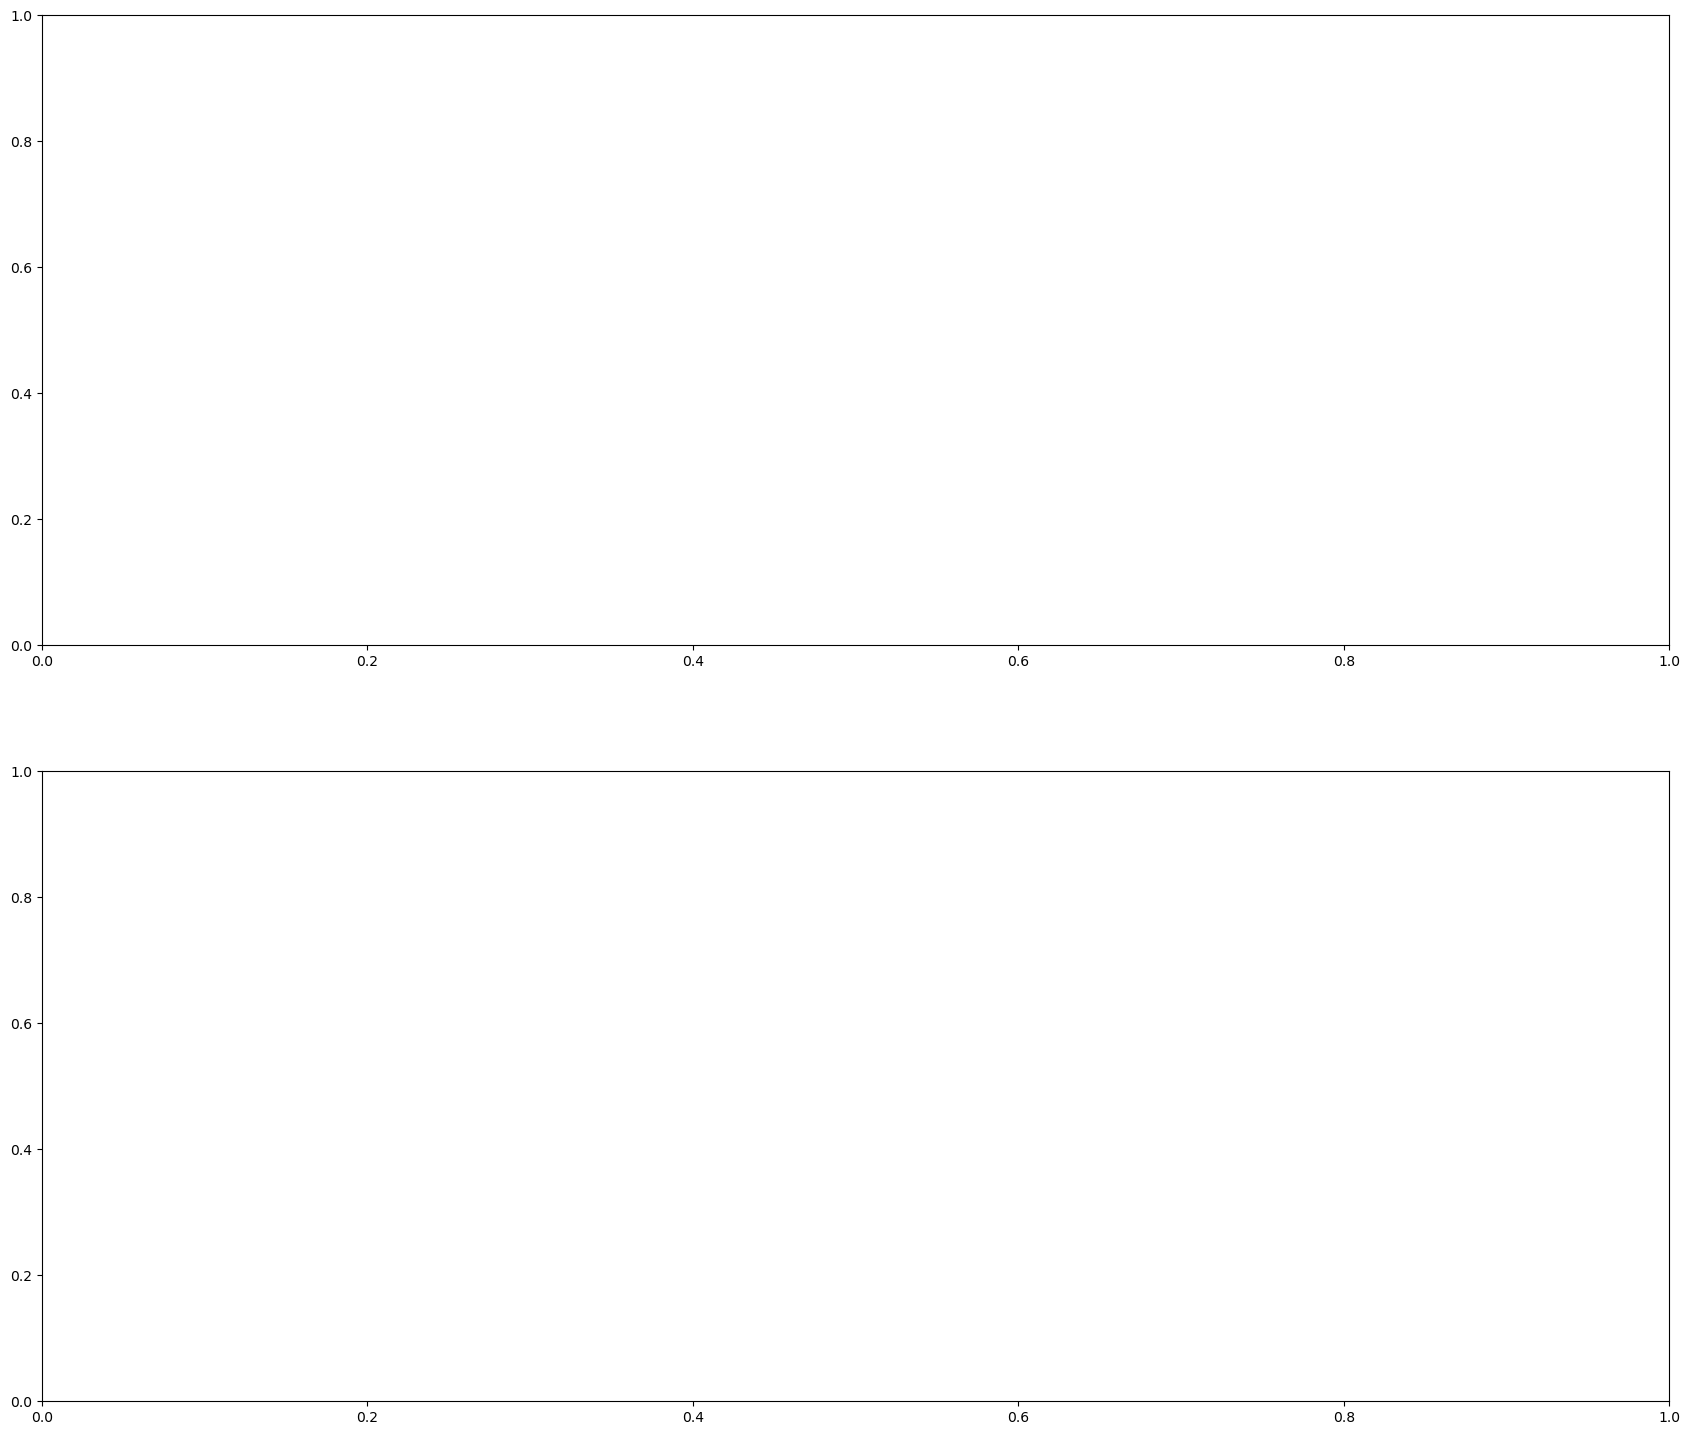

In [19]:
pr_start = 45
pr_leap = 5
pr_to = 55

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
total_day = int(total_file*internal_day)
print(total_day)


qv = np.zeros((((total_day, 20, 64, 128))))
qv_diff = np.zeros((((total_day, 20, 64, 128))))
u = np.zeros((((total_day, 20, 64, 128))))
v = np.zeros((((total_day, 20, 64, 128))))
t = np.zeros((((total_day, 20, 64, 128))))
p = np.zeros((((total_day, 20, 64, 128))))
ps = np.zeros((((total_day, 20, 64, 128))))
p_half = np.zeros((((total_day, 21, 64, 128))))

### fig
y = np.linspace(-90,90,64)
time = np.linspace(start, end, total_day)
yy, tt = np.meshgrid(y,time)
a      = int(0)
fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(21,18))
#########

do_check_qv = False
do_check_KE = True
do_check_t  = False
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_qv:
            if k ==0:
                qv[0:100,:,:,:]      = qv_ini[k,:,:,:,:]
                qv_diff[0:100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
                p_half[0:100,:,:,:]        = p_half_ini[k,:,:,:,:]            
            else:
                qv[k*100:(k+1)*100,:,:,:] = qv_ini[k,:,:,:,:]
                qv_diff[k*100:(k+1)*100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
                p_half[k*100:(k+1)*100,:,:,:] = p_half_ini[k,:,:,:,:]
                
        if do_check_KE:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
                v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
                p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
                v[k*100:(k+1)*100,:,:,:] = v_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
                
        if do_check_t:
            if k ==0:
                t[0:100,:,:,:]             = t_ini[k,:,:,:,:]
            else:
                t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
print("done")

In [11]:
# check_days_length = 800
# sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
# sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
# y               = np.linspace(-90,90,64)
# yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

# plt.figure()
# CS = plt.contourf(yy, sigma_mean2, np.nanmean(u, axis=(0,3)), levels=np.linspace(-16,45,21), cmap="RdBu_r", extend="both")
# plt.colorbar(CS)
# # print(u)
# plt.ylim([1,0])

In [20]:
pr_start = 0
pr_leap = 5
pr_to = 55

### fig
y = np.linspace(-90, 90, 64)
# yy, tt = np.meshgrid(y,time)
a      = int(0)
plt.figure(figsize=(6,4), dpi=300.)

#########

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
print(total_file)
total_day = int(total_file*internal_day)

u = np.zeros((((800, 20, 64, 128))))

do_check_u_error_bar = True
a = 0
############################################
check_days_length = 800
sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
##################################################################################
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    # print(u_ini.shape)
    # b = 0
    for k in range(total_file):
        if do_check_u_error_bar:
            if k ==0:
                u[0:100,:,:,:]           = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]

    # Step 1. given value
    u_all_mean = np.nanmean(u, axis=(3)) # (800, 20, 32)

    # Step 2. Do interpolation, increasing resolution ten times
    interpolation_times = 10
    yys           = np.linspace(0, 90, 32*interpolation_times)
    sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)
    
    # # Step 3. Do bootstrap
    total_time = 1000
    each_time = 80           # need to equal to the number of Fourier transform and wannt to see low frequency
    ### n denote to take the biggest n% in each day 
    n = 0.005

    selected_u_mean_z, selected_u_mean_y, CI_low_mean_z, CI_high_mean_z, CI_low_mean_y, CI_high_mean_y= bootstrap_y(u_all_mean[:,:,32:], total_time, each_time, n, interpolation_times, y , sigma_onlyz, yys, sigma_mean2s) # each_time need to eqaul to the amount of the number of Fourier transform

    
    y_error2  = CI_high_mean_y - np.nanmean(selected_u_mean_y)
    y_error   = np.nanmean(selected_u_mean_y) - CI_low_mean_y
    print(y_error, y_error2)

    z_error2  = CI_high_mean_z - np.nanmean(selected_u_mean_z)
    z_error   = np.nanmean(selected_u_mean_z) - CI_low_mean_z
    print(z_error, z_error2)
    
    print("PR:",f"{pr},\n z index:CI_high=",(CI_high_mean_z), "mean point=", np.nanmean(selected_u_mean_z),"CI_low=",(CI_low_mean_z))
    print("PR:",f"{pr},\n y index:CI_high=",(CI_high_mean_y), "mean point=", np.nanmean(selected_u_mean_y),"CI_low=",(CI_low_mean_y))
    ###########################################################
    print("===========================")
    print(f"PR={pr}:")
    print("y latitude:")
    
    print("CI high:", CI_high_mean_y)
    print("mean:   ", np.nanmean(selected_u_mean_y))
    print("CI low: ", CI_low_mean_y)
    print("===========================")
    print("z latitude:")
    print("CI high:", CI_high_mean_z)
    print("mean:   ", np.nanmean(selected_u_mean_z))
    print("CI low: ", CI_low_mean_z)
    print("===========================")
    ###############################################################
    plt.scatter( np.nanmean(selected_u_mean_y), np.nanmean(selected_u_mean_z), label=f"PR={pr}")
    plt.errorbar(np.nanmean(selected_u_mean_y), np.nanmean(selected_u_mean_z), xerr = np.stack([[y_error], [y_error2]]), yerr = np.stack([[z_error],[z_error2]]), fmt='o', elinewidth=2, capsize=3, ms=2) # 

    a += 1
plt.gca().invert_yaxis()
plt.title(f"200-1000 day files bootstrap {total_time} times ({each_time} time each),\n take the biggest {n} ({n*100}%) u wind of {each_time} times (interpolation {interpolation_times} times)")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.legend()
plt.savefig("PR0_50_check_u_index_bootstrap_05percentage.png", dpi=300, bbox_inches='tight')
plt.show()

8


KeyboardInterrupt: 

<Figure size 1800x1200 with 0 Axes>